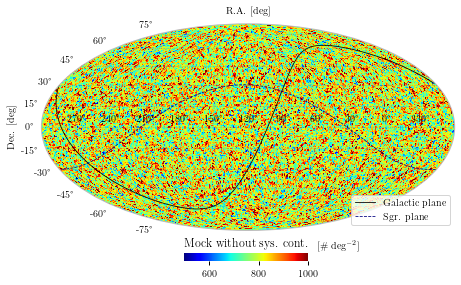

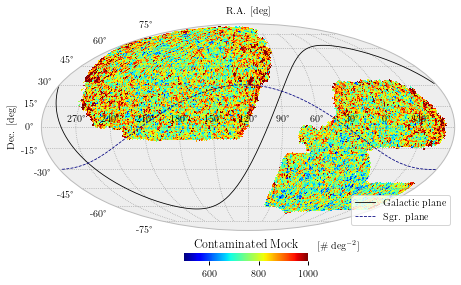

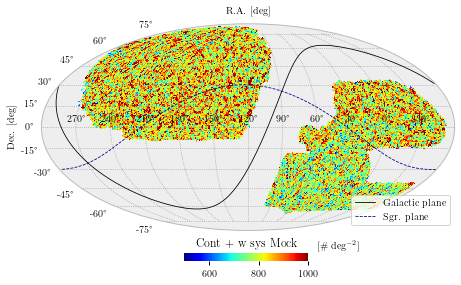

In [10]:
# Impact of the correction on the target distribution on the sky. After applying the weight, the density in DES region is lower as obserbed in the target density

to_plot = expected_mock_map.copy()
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Mock without sys. cont.')

to_plot = cont_mock_map.copy()
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Contaminated Mock')

to_plot = cont_mock_map.copy() * wsys_new.map
to_plot[to_plot == 0] = np.NaN
plot_moll(hp.ud_grade(to_plot, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=500, max=1000, figsize=(7, 5), title='Cont + w sys Mock')

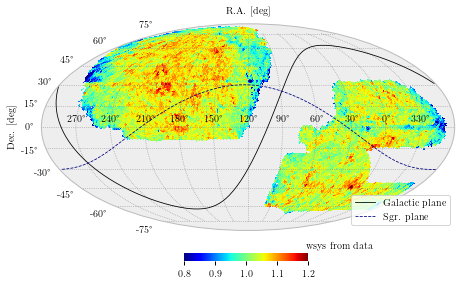

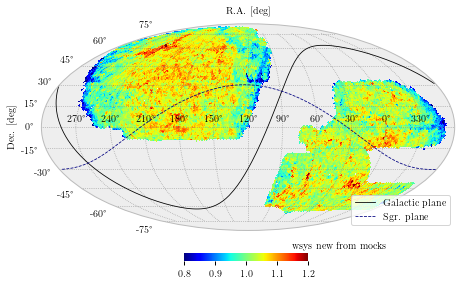

In [11]:
# We compare the weight from data used to contaminated mock and the computed weight from Mock
plot_moll(hp.ud_grade(wsys.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=0.8, max=1.2, figsize=(7, 5), label='wsys from data')
plot_moll(hp.ud_grade(wsys_new.map, 64, order_in='NESTED'), galactic_plane=True, sgr_plane=True, min=0.8, max=1.2, figsize=(7, 5), label='wsys new from mocks')

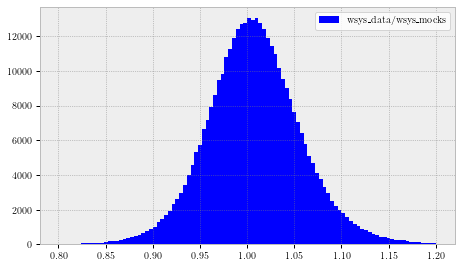

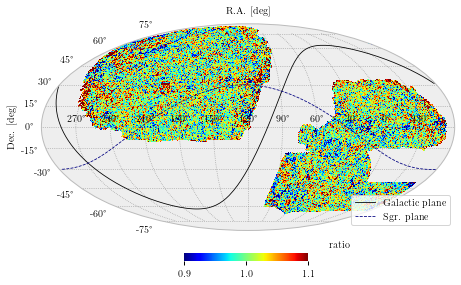

In [12]:
# Compare imaging systematic weight estimated from the data and those estimated from mocks:
ratio = wsys.map / wsys_new.map 

plt.figure(figsize=(6.55, 4))
plt.hist(ratio, bins=100, range=(0.8, 1.2), label='wsys_data/wsys_mocks')
plt.legend()
plt.show()

plot_moll(ratio, galactic_plane=True, sgr_plane=True, min=0.9, max=1.1, figsize=(7, 5), label='ratio')


The systematic plots computed from real data are available for LRG in img directory

[000049.70] 22-04-26 03:08  Systematics          INFO     Work with North
[000050.70] 22-04-26 03:08  Systematics          INFO     Keep only pixels with fracarea > 0
[000050.70] 22-04-26 03:08  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


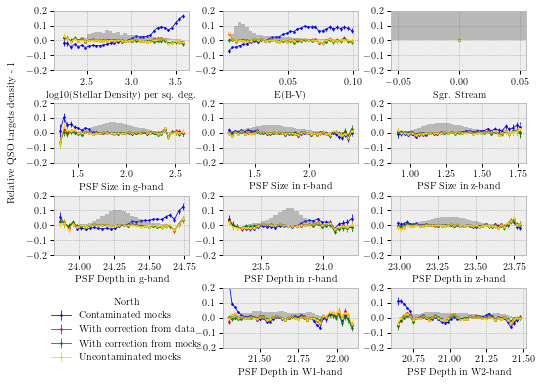

[000054.93] 22-04-26 03:08  Systematics          INFO     Work with South
[000055.89] 22-04-26 03:08  Systematics          INFO     Keep only pixels with fracarea > 0
[000055.90] 22-04-26 03:08  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


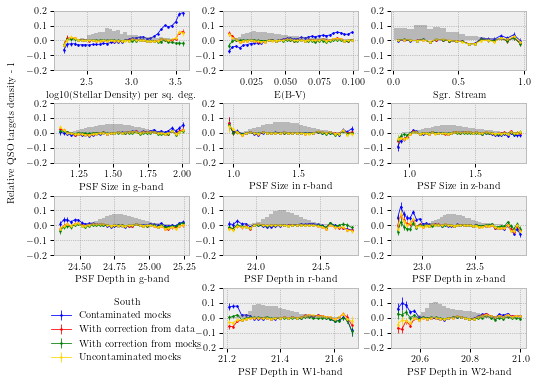

[000061.01] 22-04-26 03:08  Systematics          INFO     Work with Des
[000061.96] 22-04-26 03:08  Systematics          INFO     Keep only pixels with fracarea > 0
[000061.97] 22-04-26 03:08  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


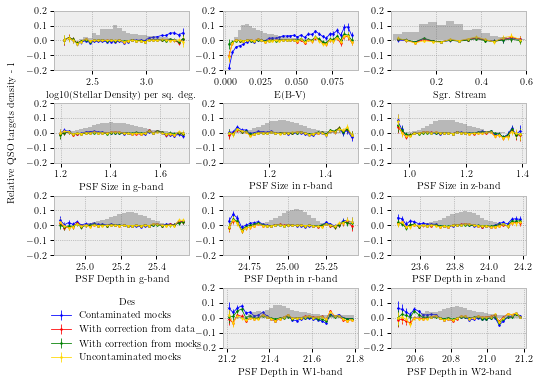

In [13]:
# Systematic plots

print("\nThe systematic plots computed from real data are available for LRG in img directory\n")

with np.errstate(invalid='ignore'): # avoid error with nan values 
    plot_systematic_from_map([dataframe.targets, dataframe.targets*wsys.map, dataframe.targets*wsys_new.map, expected_mock_map], 
                             ['Contaminated mocks', 'With correction from data', 'With correction from mocks', 'Uncontaminated mocks'], 
                              dataframe.fracarea, dataframe.footprint, dataframe.features, dataframe.regions,
                              ax_lim=0.2, legend_title=True, hist_legend=False, cut_fracarea=True, limits_fracarea=(0.9, 1.1), show=True, save=False, savedir='')

[000066.11] 22-04-26 03:09  Systematics          INFO     Work with North
[000067.09] 22-04-26 03:09  Systematics          INFO     Keep only pixels with fracarea > 0
[000067.09] 22-04-26 03:09  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


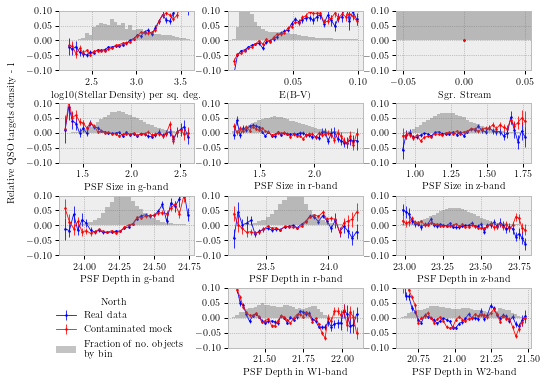

[000070.29] 22-04-26 03:09  Systematics          INFO     Work with South
[000071.24] 22-04-26 03:09  Systematics          INFO     Keep only pixels with fracarea > 0
[000071.24] 22-04-26 03:09  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


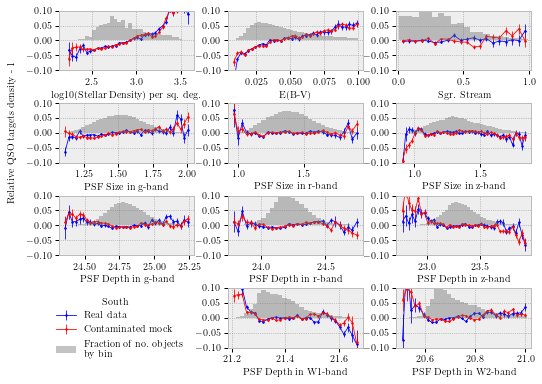

[000075.24] 22-04-26 03:09  Systematics          INFO     Work with Des
[000076.15] 22-04-26 03:09  Systematics          INFO     Keep only pixels with fracarea > 0
[000076.16] 22-04-26 03:09  Systematics          INFO     Keep only pixels with 0.9 < fracarea < 1.1


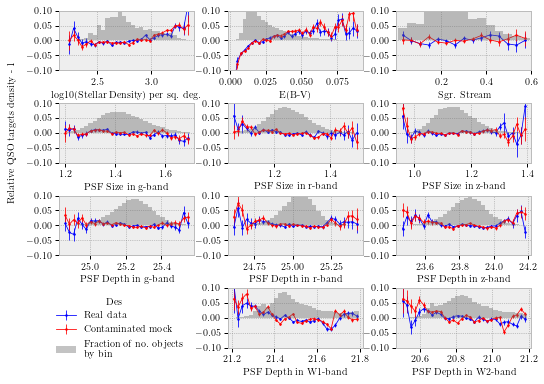

In [14]:
# Compare real data to contaminated mock:

data_map = np.load(os.path.join(data_dir, 'SV3_LRG_256.npy'))

with np.errstate(invalid='ignore'): # avoid error with nan values 
    plot_systematic_from_map([data_map, dataframe.targets], 
                             ['Real data', 'Contaminated mock'], 
                              dataframe.fracarea, dataframe.footprint, dataframe.features, dataframe.regions,
                              ax_lim=0.1, cut_fracarea=True, limits_fracarea=(0.9, 1.1), legend_title=True, show=True, save=False)

## Compute power spectrum:

**Requierement**: ``pypower`` (https://github.com/adematti/pypower) and ``cosmoprimo`` (https://github.com/cosmodesi/cosmoprimo)

In [1]:
import os
import logging
import fitsio as ft
from glob import glob

#from regressis import PhotoWeight
#from regressis.mocks import create_flag_imaging_systematic
from regressis.utils import setup_logging, setup_mplstyle

#setup_logging()

logger = logging.getLogger("Notebook")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

#from regressis import PhotometricDataFrame, Regression, DR9Footprint
#from regressis.utils import build_healpix_map
#from regressis.plot import plot_moll
#from regressis.systematics import plot_systematic_from_map

In [3]:
from pypower import CatalogFFTPower

# Set cosmology to transform redshift to distance
from cosmoprimo.fiducial import DESI
distance = DESI(engine='class').comoving_radial_distance  

### Functions

In [4]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def hpix2radec(nside, hpix):
    """
    Function transforms HEALPix index (ring) to RA, DEC
    
    parameters 
    ----------
    nside : int
        
    hpix : array_like
        HEALPix indices
    
    returns
    -------
    ra : array_like
        right ascention in deg
        
    dec : array_like
        declination in deg
        
    """
    theta, phi = hp.pixelfunc.pix2ang(nside, hpix)
    return np.degrees(phi), 90-np.degrees(theta)

def project2hp(nside, mock, weight=None, return_hpix=False):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    hpmap = np.bincount(hpix, weights=weight, minlength=12*nside*nside)
    if return_hpix:
        return hpmap, hpix
    else:
        return hpmap
    
def normalize_selection_func(ngal_pred):
    # get nside from the selection function
    nside = hp.get_nside(ngal_pred)
    
    # normalize the selection function to [0, 1]
    good = ngal_pred>0
    vmin, vmax = ngal_pred[good].min(), ngal_pred[good].mean() #np.percentile(ngal_pred[good], [0, 100])
    selection_func = np.zeros_like(ngal_pred)
    selection_func[good] = (ngal_pred[good]/vmax)#-vmin) / (vmax-vmin)
    return selection_func

def normalize_selection_func1(ngal_pred, mock_hpix=None):
    # get nside from the selection function
    nside = hp.get_nside(ngal_pred)
    
    # normalize the selection function by mean
    if mock_hpix is not None:
        ngal_pred = ngal_pred[mock_hpix]
    good = ngal_pred>0
    vmin, vmax = ngal_pred[good].min(), ngal_pred[good].mean() #np.percentile(ngal_pred[good], [0, 100])
    selection_func = np.zeros_like(ngal_pred)
    selection_func[good] = (ngal_pred[good]/vmax)#-vmin) / (vmax-vmin)
    return selection_func

def downsample(selection_func, mock):
    """ downsample a mock catalog with a given selection function """
    nside = hp.get_nside(selection_func)
    hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
    prob = selection_func[hpix]    
    good = np.random.uniform(size=mock.size) < prob
    return mock[good]

def _desi_mock_filename(tracer='LRG', ph=0):
    """Collect the name of DESI Mocks in NERSC."""
    mock_dir='/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/'
    z_dic={'LRG':0.8,'ELG':1.1,'QSO':1.4}
    fname=f'{mock_dir}{tracer}/z{z_dic[tracer]:5.3f}/cutsky_{tracer}_z{z_dic[tracer]:5.3f}_AbacusSummit_base_c000_ph{ph:003d}.fits'
    return fname

def _selection_function_filename(tracer='LRG', ind=0):
    """Collect selection function obtained from NN."""
    tracer = tracer.lower() # after testing make a directory by tracer
    fname=f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{ind}.hp256.fits'
    return fname

def _selection_function_filename_mean(tracer='LRG'):
    """Collect selection function obtained from NN."""
    tracer = tracer.lower() # after testing make a directory by tracer
    fname=f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits'
    return fname

def make_hp(value, hpix, nside, fill_with=np.nan):
    """ A Function to create a HEALPix map
    """
    m_ = np.zeros(12*nside*nside)
    m_[:] = fill_with
    m_[hpix] = value
    
    return m_

def get_mock_hpmap(contaminated=False, selection_fn=None, nside=256, tracer='LRG', ph=0, main=0, nz=1, Y5=1, sv3=0):
    # read the mock catalog
    mock_name = _desi_mock_filename(tracer=tracer, ph=ph)
    print(f'using {mock_name}')
    mock = apply_mock_mask(mock_name, main=main, nz=nz, Y5=Y5, sv3=sv3) # mask Y5 by default
    
    if contaminated:
        assert selection_fn is not None, "provide selection function"
        # normalize the selection function to [0, 1]
        selection_func = normalize_selection_func(selection_fn)
        # subsample the mock catalog, and project to HEALPix
        mock = downsample(selection_func, mock)
        
    mock_hpmap = project2hp(nside, mock)
    return mock_hpmap

def get_mock(contaminated=False, selection_fn=None, nside=256, tracer='LRG', ph=0, return_hpix=False, main=0, nz=1, Y5=1, sv3=0):
    # read the mock catalog
    mock_name = _desi_mock_filename(tracer=tracer, ph=ph)
    print(f'using {mock_name}')
    mock = apply_mock_mask(mock_name, main=main, nz=nz, Y5=Y5, sv3=sv3) # mask Y5 by default
    
    if contaminated:
        assert selection_fn is not None, "provide selection function"
        print('contaminating mock')
        # normalize the selection function to [0, 1]
        selection_func = normalize_selection_func(selection_fn)
        # subsample the mock catalog, and project to HEALPix
        mock = downsample(selection_func, mock)
        
    if return_hpix:
        hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
        return mock, hpix
    else:
        return mock
    
def mock_mask(main=0, nz=0, Y5=0, sv3=0):
    #https://desi.lbl.gov/trac/attachment/wiki/CosmoSimsWG/FirstGenerationMocks/STATUS_script_example.py
    return main * (2**3) + sv3 * (2**2) + Y5 * (2**1) + nz * (2**0)

def apply_mock_mask(filename, main=0, nz=1, Y5=1, sv3=0):
    #https://desi.lbl.gov/trac/attachment/wiki/CosmoSimsWG/FirstGenerationMocks/STATUS_script_example.py
    ## Default value chooses the Y5 footprint and downsampled to input n(z)
    data = ft.read(filename)
    STATUS = data["STATUS"]

    ### Array of indices
    idx = np.arange(len(STATUS))
    
    #apply mask to get desired sample
    print(f'applying mask: main={main}, nz={nz}, Y5={Y5}, sv3={sv3}')
    mask = mock_mask(main=main, nz=nz, Y5=Y5, sv3=sv3) # mask Y5 by default
    idx_good = idx[(STATUS & (mask))==mask]
    return data[idx_good]

In [5]:
#function for computing power spectrum by Edmond
def compute_power(data, randoms, data_weights=None, randoms_weights=None, ells=(0, 2, 4), edges=None, return_plot=False, nmesh=512):
    if edges is None:
        logger.info('Use default edges: np.linspace(0, 0.3, 81)')
        edges = np.linspace(0, 0.3, 81)
    
    # set data weights
    if data_weights is None:
        data_weights = np.ones(data['RA'].size)
    
    # set randoms weights
    if randoms_weights is None:
        randoms_weights = np.ones(randoms['RA'].size)
    
    result = CatalogFFTPower(data_positions1=[data['RA'], data['DEC'], distance(data['Z'])], data_weights1=data_weights,
                             randoms_positions1=[randoms['RA'], randoms['DEC'], distance(randoms['Z'])], randoms_weights1=randoms_weights,
                             edges=edges, ells=ells, interlacing=2, boxsize=None, boxpad=4, nmesh=nmesh, resampler='tsc',
                             los=None, position_type='rdd', mpiroot=0)
    if return_plot:
        return result.poles.k, result.poles

### code

In [6]:
# here we read data used for NN training, also make ngal healpix map for all regions

hpmap = np.zeros(12*256*256)
count = np.zeros(12*256*256)
frac = np.zeros(12*256*256)


for region in ['bmzls', 'ndecals', 'sdecals']:
    d = ft.read(f'/global/cscratch1/sd/arosado/nlrg_features_{region}_256.fits')
    hpmap[d['hpix']] += d['label']
    frac[d['hpix']] += d['fracgood']
    count[d['hpix']] += 1.0

ngal = hpmap# / count

In [7]:
nside = 256
# 
# get NN-weights
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits')
#nn_test1 = np.load('nn-weights.hp256.npy')

#hpix = np.where(nn_test1 != hp.UNSEEN)
#nn_mask = make_hp(1.0, hpix, nside) > 0.5

nn_normed = normalize_selection_func(nn_test1)
#ra,dec = hpix2radec(nside, hpix)
#m = make_hp((nn_test1[hpix] / nn_test1[hpix].mean()), hpix, nside)
#hp.mollview(m)

In [8]:
%%time
# get uncontaminated mock and contaminated mock (contaminated mock by downsampling), and project them to healpix maps
mock_uncont, mock_uncont_pix_number = get_mock(contaminated=False, selection_fn=None, nside=256, tracer='LRG', ph=0, return_hpix=True)
mock_uncont_hmap = project2hp(nside, mock_uncont)
#uncont_mask = make_hp(1.0, mock_uncont_pix_number, nside) > 0.5

mock_cont, mock_cont_pix_number = get_mock(contaminated=True, selection_fn=nn_normed, nside=256, tracer='LRG', ph=0, return_hpix=True)
mock_cont_hmap = project2hp(nside, mock_cont)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=1, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=1, Y5=1, sv3=0
contaminating mock
CPU times: user 9.33 s, sys: 9.36 s, total: 18.7 s
Wall time: 22.1 s


In [9]:
# contaminate mock by dividing by normalized nn weights
mock_cont_hmap2 = project2hp(nside, mock_uncont, weight=(1./nn_normed[mock_uncont_pix_number]))

/tmp/ipykernel_34908/976196083.py:2: RuntimeWarning: divide by zero encountered in divide
  mock_cont_hmap2 = project2hp(nside, mock_uncont, weight=(1./nn_normed[mock_uncont_pix_number]))


In [11]:
mask = (mock_cont_hmap>0) & (mock_cont_hmap2>0) & (mock_cont_hmap2>0)
mock_uncont_hmap[mask].mean(), mock_cont_hmap[mask].mean(), mock_cont_hmap2[mask].mean()

(42.09584042125176, 41.602069554537564, 42.1941559565482)

<timed exec>:12: RuntimeWarning: divide by zero encountered in divide
<timed exec>:12: RuntimeWarning: invalid value encountered in divide


CPU times: user 1.84 s, sys: 634 ms, total: 2.47 s
Wall time: 1.64 s


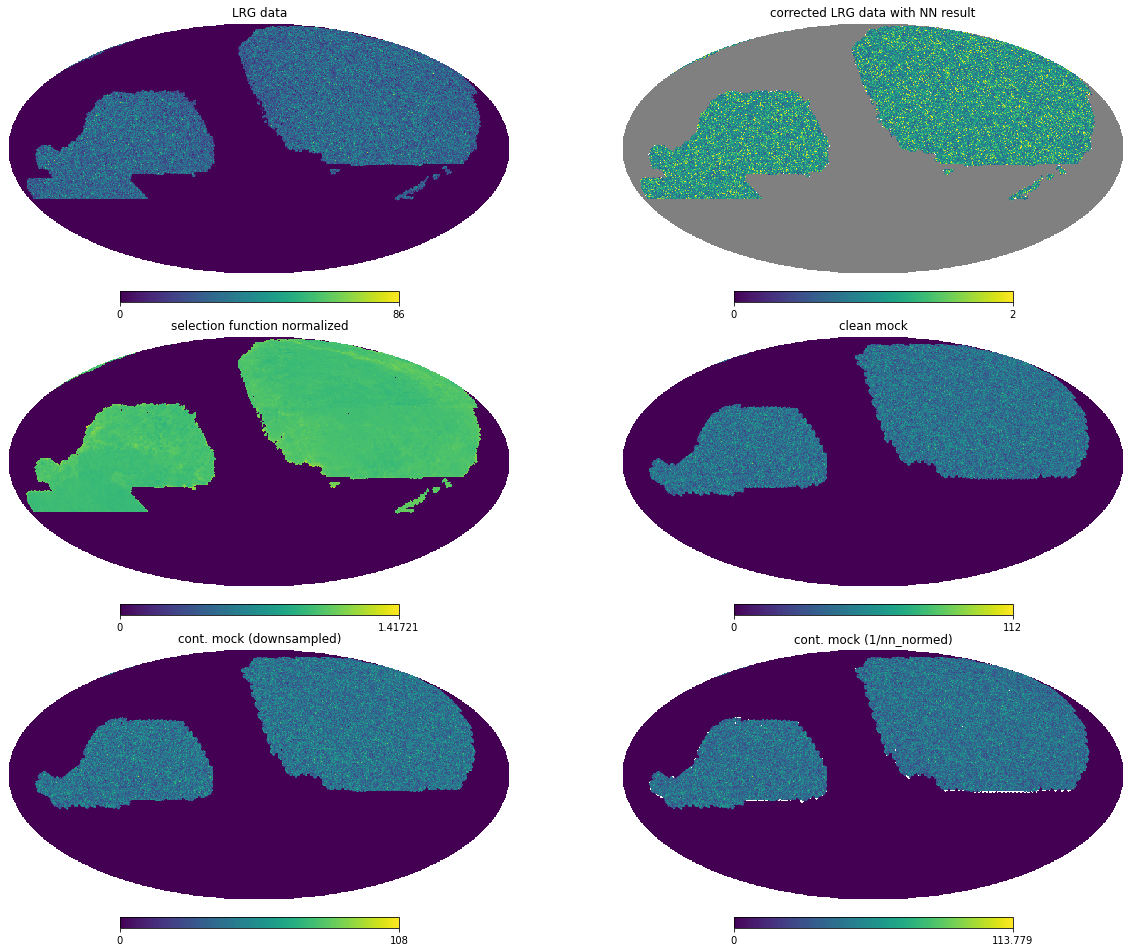

In [17]:
%%time
plot_dir = '/global/homes/a/arosado/sysgen/plots'

fig, ax = plt.subplots(nrows=3, ncols=2)
ax = ax.flatten()
fig.set_size_inches(21, 17)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

plt.sca(ax[0])    
hp.mollview(ngal, title='LRG data', hold=True, rot=-85)

plt.sca(ax[1])
hp.mollview(nn_test1*frac/ngal, title='corrected LRG data with NN result', min=0, max=2, hold=True, rot=-85)

plt.sca(ax[2])
hp.mollview(nn_normed, title='selection function normalized', hold=True, rot=-85)

plt.sca(ax[3])
hp.mollview(mock_uncont_hmap, title='clean mock', hold=True, rot=-85)

plt.sca(ax[4])
hp.mollview(mock_cont_hmap, title='cont. mock (downsampled)', hold=True, rot=-85)

plt.sca(ax[5])
hp.mollview(mock_cont_hmap2, title='cont. mock (1/nn_normed)', hold=True, rot=-85)

fn = os.path.join(plot_dir, f'hpmaps_v2.png')
#print(f'saving {fn}')
#plt.savefig(fn, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')

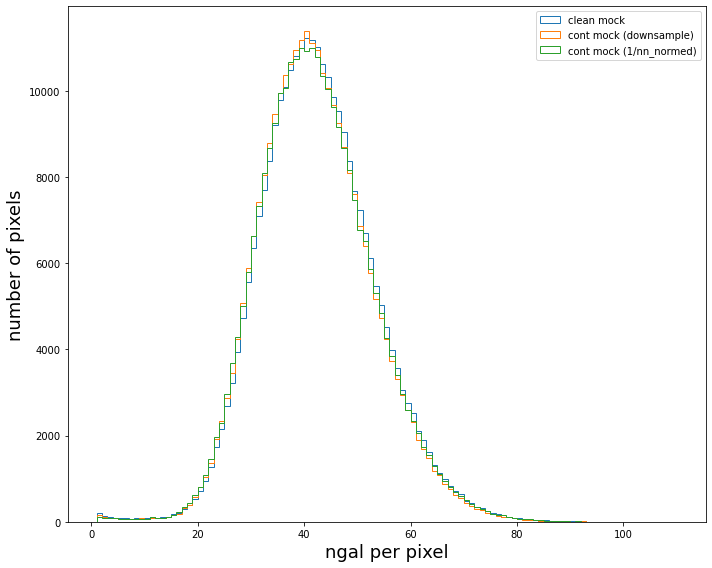

In [14]:
plt.figure(figsize=(10, 8))
plt.hist(mock_uncont_hmap, histtype='step', bins=np.linspace(1.0, 110, num=110), label='clean mock')
plt.hist(mock_cont_hmap, histtype='step', bins=np.linspace(1.0, 110, num=110), label='cont mock (downsample)')
plt.hist(mock_cont_hmap2, histtype='step', bins=np.linspace(1.0, 110, num=110), label='cont mock (1/nn_normed)')
#plt.hist(mock_uncont['Z'], histtype='step', bins=100, range=(0.0, 2.4), label='expected n(z)')
#plt.hist(mock_cont['Z'], histtype='step', bins=100, range=(0.0, 2.4), label='cont mock n(z) (downsample)')
plt.legend()
plt.xlabel('ngal per pixel', fontsize=18)
plt.ylabel('number of pixels', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
#nmock_contaminated = nmock_null / (A x nntest)
#then find A such that sum(nmock_contaminated) = sum(nmock_null)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


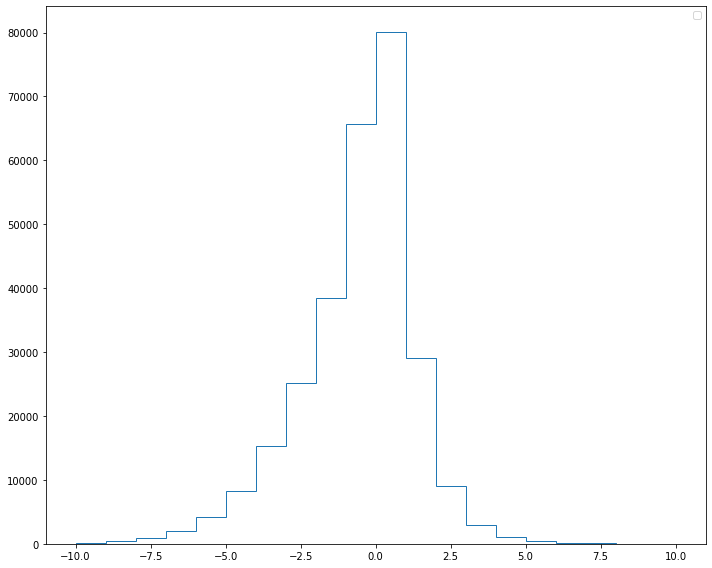

In [24]:
plt.figure(figsize=(10, 8))
mask = (mock_cont_hmap>0) & (mock_cont_hmap2>0)
plt.hist(mock_cont_hmap[mask] - mock_cont_hmap2[mask], histtype='step', bins=np.linspace(-10, 10, num=21))
plt.legend()
#plt.xlabel('z')
plt.tight_layout()
plt.show()

In [31]:
y,x = np.histogram(mock_uncont_hmap, bins=100, range=(0.1, 110))
np.argmax(y)
x[39]

42.961

In [13]:
# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = apply_mock_mask(randoms_path, main=0, nz=1, Y5=1, sv3=0)

# project randoms to healpix map
randoms_hmap, randoms_pix_number = project2hp(nside, randoms, return_hpix=True)
#hp.mollview(randoms_hmap)

applying mask: main=0, nz=1, Y5=1, sv3=0


322


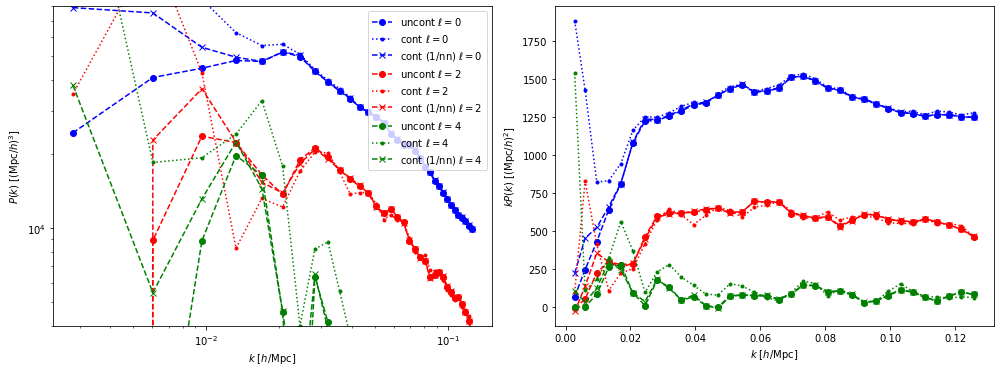

CPU times: user 1.93 s, sys: 376 ms, total: 2.31 s
Wall time: 2.07 s


In [12]:
%%time 
regions = ['']
z_min, z_max = 0.4, 0.6

plt.figure(figsize=(14, 15))
fig = plt.gcf()
#fig.set_size_inches(5, 5)

j = 0
for region in regions:
    sel_in_randoms = mask[randoms_pix_number] & (randoms['Z'] <= z_max) & (randoms['Z'] >= z_min) 
    sel_in_mock_uncont = mask[mock_uncont_pix_number] & (mock_uncont['Z'] <= z_max) & (mock_uncont['Z'] >= z_min) 
    sel_in_mock_cont = mask[mock_cont_pix_number] & (mock_cont['Z'] <= z_max) & (mock_cont['Z'] >= z_min) 

    ra, dec = mock_uncont[sel_in_mock_uncont]['RA'], mock_uncont[sel_in_mock_uncont]['DEC']
    hpix_for_nn = radec2hpix(nside, ra, dec)
    nn = nn_test1[hpix_for_nn] / nn_test1[hpix_for_nn].mean()
    
    #k, poles = compute_power(mock_uncont[sel_in_mock_uncont], randoms[sel_in_randoms], return_plot=True)
    #k2, poles2 = compute_power(mock_cont[sel_in_mock_cont], randoms[sel_in_randoms], return_plot=True)
    #k3, poles3 = compute_power(mock_uncont[sel_in_mock_uncont], randoms[sel_in_randoms], data_weights=1./nn, return_plot=True)

    plt.subplot(321+j)
    j += 1
    print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[i], ls='--', label='uncont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='.', color=color[i], ls=':', label='cont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(4e3, 8e4)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')

    plt.subplot(321+j)
    j+=1
    color = ['b', 'r', 'g']
    for i, ell in enumerate(poles.ells):
        plt.plot(k, k*poles(ell=ell, complex=False), marker='o', color=color[i], ls='--', label='uncont $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles2(ell=ell, complex=False), marker='.', color=color[i], ls=':', label='cont $\ell = {:d}$'.format(ell))
        plt.plot(k, k*poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    #plt.legend()
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.tight_layout()
#plt.savefig('Mock_LRG_power_test3.pdf')
plt.show()

#print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
#print('Normalization is {:.4f}.'.format(poles.wnorm))

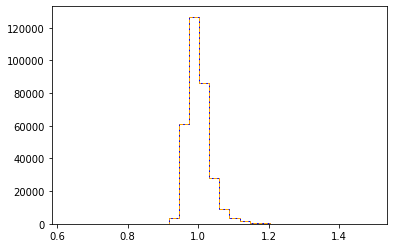

In [41]:
def normalize_selection_func(ngal_pred):
    # get nside from the selection function
    nside = hp.get_nside(ngal_pred)
    
    # normalize the selection function to [0, 1]
    good = ngal_pred>0
    vmin, vmax = ngal_pred[good].min(), ngal_pred[good].mean() #np.percentile(ngal_pred[good], [0, 100])
    selection_func = np.zeros_like(ngal_pred)
    selection_func[good] = (ngal_pred[good]/vmax)#-vmin) / (vmax-vmin)
    return selection_func[good]

plt.hist(nn_normed[mask], bins=30, color='b', histtype='step')
plt.hist(normalize_selection_func(nn_test1),bins=30, color='orange', histtype='step',ls='--')
plt.show()



[000383.08] 22-10-03 11:40  Notebook             INFO     Use default edges: np.linspace(0, 0.3, 81)
[000386.82] 22-10-03 11:40  CatalogFFTPower      INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[12277.23087379 12277.23087379 12277.23087379], boxcenter=[-4.32108779e-02 -9.42811210e+00  3.71173825e+02], dtype=float64).
[000386.95] 22-10-03 11:40  CatalogMesh          INFO     Slab 0 ~ 4194304 / 2607806.
[000388.32] 22-10-03 11:40  CatalogMesh          INFO     Painted 2607806 out of 2607806 objects to mesh.
[000388.39] 22-10-03 11:40  CatalogMesh          INFO     Slab 0 ~ 4194304 / 2596376.
[000389.76] 22-10-03 11:40  CatalogMesh          INFO     Painted 2596376 out of 2596376 objects to mesh.
[000389.77] 22-10-03 11:40  CatalogMesh          INFO     Running interlacing at order 2.
[000390.32] 22-10-03 11:40  CatalogMesh          INFO     Slab 0 ~ 4194304 / 2607806.
[000391.62] 22-10-03 11:40  CatalogMesh          INFO     Painted 2607806 out of 2607806

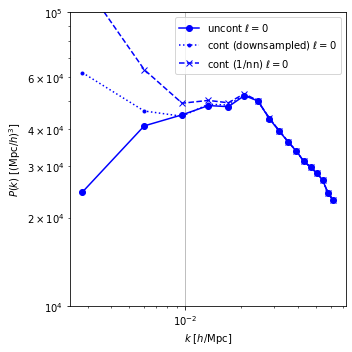

CPU times: user 20.3 s, sys: 3.31 s, total: 23.6 s
Wall time: 23.3 s


In [13]:
%%time 
regions = ['']#['North', 'South', 'Des']
z_min, z_max = 0.4, 0.6

#plt.figure(figsize=(5, 6))
fig = plt.gcf()
fig.set_size_inches(5, 5)

j = 0
for region in regions:
    sel_in_randoms = mask[randoms_pix_number] & (randoms['Z'] <= z_max) & (randoms['Z'] >= z_min) 
    sel_in_mock_uncont = mask[mock_uncont_pix_number] & (mock_uncont['Z'] <= z_max) & (mock_uncont['Z'] >= z_min) 
    sel_in_mock_cont = mask[mock_cont_pix_number] & (mock_cont['Z'] <= z_max) & (mock_cont['Z'] >= z_min) 
    
    ra, dec = mock_uncont[sel_in_mock_uncont]['RA'], mock_uncont[sel_in_mock_uncont]['DEC']
    hpix_for_nn = radec2hpix(nside, ra, dec)
    nn = nn_normed[hpix_for_nn]
    
    #k, poles = compute_power(mock_uncont[sel_in_mock_uncont], randoms[sel_in_randoms], ells=(0), return_plot=True, nmesh=256)
    #k2, poles2 = compute_power(mock_cont[sel_in_mock_cont], randoms[sel_in_randoms], ells=(0), return_plot=True, nmesh=256)
    k3, poles3 = compute_power(mock_uncont[sel_in_mock_uncont], randoms[sel_in_randoms], ells=(0), data_weights=nn, return_plot=True, nmesh=256)

    #plt.subplot(131+j)
    j += 1
    #print(321+j)
    color = ['b', 'r', 'g']
    for i, ell in enumerate([poles.ells[0]]):
        plt.plot(k, poles(ell=ell, complex=False), marker='o', color=color[i], ls='-', label='uncont $\ell = {:d}$'.format(ell))
        plt.plot(k, poles2(ell=ell, complex=False), marker='.', color=color[i], ls=':', label='cont (downsampled) $\ell = {:d}$'.format(ell))
        plt.plot(k, poles3(ell=ell, complex=False), marker='x', color=color[i], ls='--', label='cont (1/nn) $\ell = {:d}$'.format(ell))
    plt.legend(title=region, loc='upper right')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1e4, 1e5)
    plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
    plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
    plt.grid(True)

plt.tight_layout()
#plt.savefig('Mock_LRG_power_test2.pdf')
plt.show()

In [19]:
mock_cont[sel_in_mock_cont]['RA'].size, mock_uncont[sel_in_mock_uncont]['RA'].size, mock_cont[sel_in_mock_cont]['RA'].size/mock_uncont[sel_in_mock_uncont]['RA'].size, nn.sum()

(2576131, 2607806, 0.9878537743988625, 2607865.35385661)

In [25]:
(1/nn_normed[hpix_for_nn]).mean(), (1/nn_test1).mean()

(1.0010151952642476, 0.012953546067751696)

In [ ]:
mock_cont[sel_in_mock_cont]['RA'].size/mock_uncont[sel_in_mock_uncont]['RA'].size

In [ ]:
# flag for expected n(z) mock
sel_nz = mock['STATUS'] & 2**0 != 0
sel_nz_ = mock_after['STATUS'] & 2**0 != 0

plt.figure(figsize=(5, 4))
plt.hist(mock['Z'], histtype='step', bins=100, range=(0.0, 2.4), label='before')
plt.hist(mock_after['Z'], histtype='step', bins=100, range=(0.0, 2.4), label='after')
plt.legend()
plt.xlabel('z')
plt.tight_layout()
plt.show()

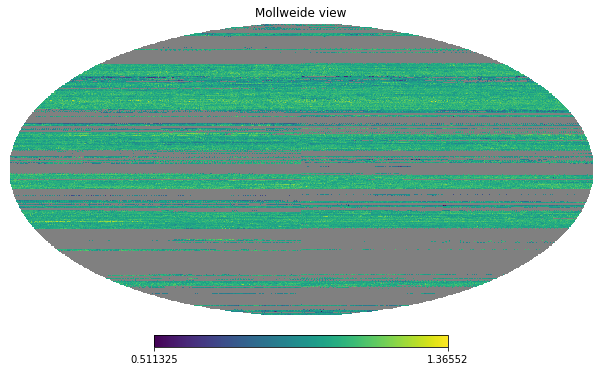

In [14]:
version = 'SV3'
tracer = 'LRG'

data_dir = '/global/homes/a/arosado/regressis/regressis/tests/test_data'
m = np.load(os.path.join(data_dir, f'{version}_{tracer}_imaging_weight_256.npy'), allow_pickle=True).item()['map']
hp.mollview(m, )
        

In [33]:
# Load photometric weight
wsys = PhotoWeight.load(os.path.join(data_dir, f'{version}_{tracer}_imaging_weight_256.npy'))
wsys #help(wsys)

[003189.47] 22-10-02 18:25  PhotoWeight          INFO     Load PhotoWeight class from /global/homes/a/arosado/regressis/regressis/tests/test_data/SV3_LRG_imaging_weight_256.npy


AttributeError: 'PhotoWeight' object has no attribute 'ra'

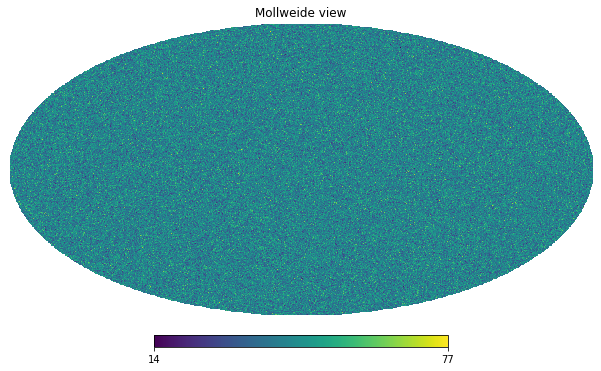

In [18]:
# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = ft.read(randoms_path)
# keep only randoms with correct n(z) distribution 
randoms = randoms[randoms['STATUS'] & 2**0 != 0]
# project randoms to healpix map
randoms_hmap = project2hp(nside, randoms)
hp.mollview(randoms_hmap)

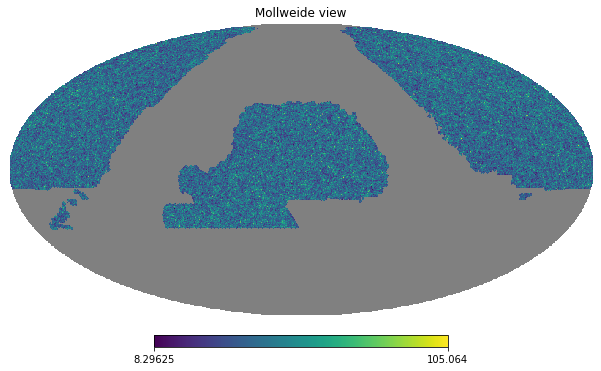

In [21]:
#clean_mock = make_hp(get_mock_hpmap(ph=0)[hpix],hpix,nside)
clean_mock = get_mock_hpmap(ph=0)
hp.mollview(clean_mock/m)